# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [16]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000
print("Income types: ", data['income'].unique() )
n_greater_50k = len(data[data['income'] == ">50K"].index)

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == "<=50K"].index)

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)/n_records*100.0

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

('Income types: ', array(['<=50K', '>50K'], dtype=object))
Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

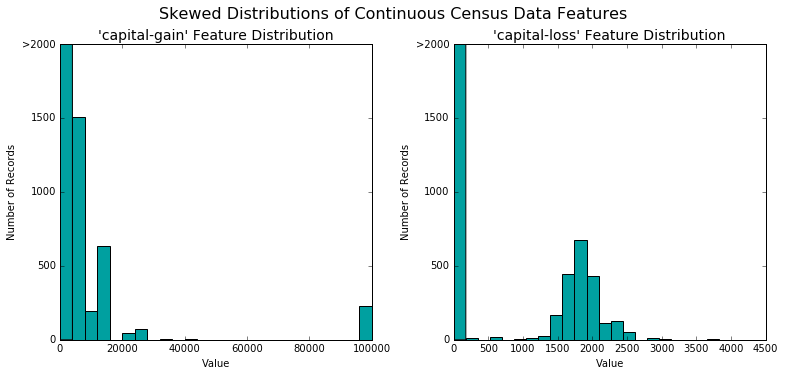

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

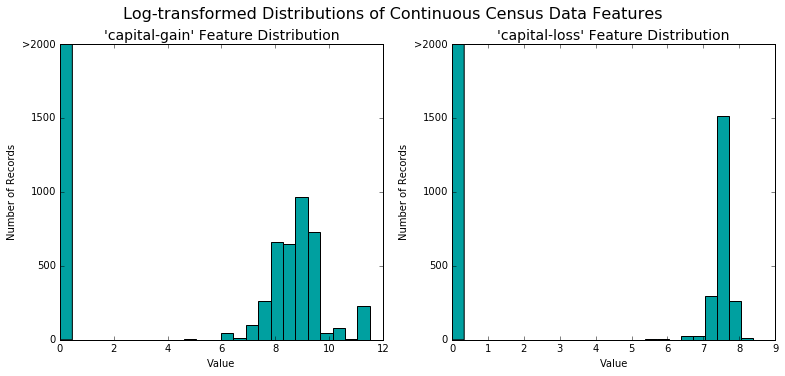

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)
display(features.head())

# Encode the 'income_raw' data to numerical values
income = income_raw.map(lambda x: 0 if x == "<=50K" else 1)
display(income_raw.head(10))
display(income.head(10))

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.400000,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.800000,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
5    <=50K
6    <=50K
7     >50K
8     >50K
9     >50K
Name: income, dtype: object

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# Calculate accuracy
prediction = np.asarray([1]*n_records)

true_positives = income[(income == 1) & (prediction == 1)].count()
true_negatives = income[(income == 0) & (prediction == 0)].count()
false_positives = income[(income == 0) & (prediction == 1)].count()
false_negatives = income[(income == 1) & (prediction == 0)].count()

accuracy = float(true_positives+true_negatives)/n_records

# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
precision = float(true_positives)/(true_positives+false_positives)
recall = float(true_positives)/(true_positives+false_negatives)
fscore = (1+beta**2) * (precision*recall)/((precision*beta**2)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

# Check against sklearn calcs
from sklearn.metrics import accuracy_score, fbeta_score
print ( "SKLearn Accuracy: ", accuracy_score(income, prediction), "SKLearn F-score", fbeta_score(income, prediction, beta) )

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
('SKLearn Accuracy: ', 0.24784396974923709, 'SKLearn F-score', 0.29172913543228385)


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

All models have been selected due to their inherent support for Classification type relationships.  Three models have been selected - Naive Bayes, Decision Trees and Support Vector Machines with some key information on each<sup>[1][2]</sup>:
<h3>Naive Bayes (GaussianNB)</h3>
- This model has been used for medical and biological applications, for example to predict DNA-binding proteins to help advance our  understanding of protein functions.<sup>[3]</sup>  Comparing other machine learning frameworks, the model performed best due to its abililty to handle lots of features.
- **Strengths:**  Naive Bayes performs well when inputs are independent from one another, and when there are many features
    - Few parameters so it's hard to overfit
    - Fast training speed
    - Good at seperating signal from noise
    - Able to handle many features
- **Weaknesses:** Naive Bayes performs badly for problems where probabilities are sometimes greater than zero for a particular classification.
    - Simplistic nature can yield bad generalizations or suboptimal solutions
    - Doesn't account for interactions between features
    - There is a high bias when there is a small amount of data
- **Applicability:** After one-hot encoding, our data has a lot of features - 103 in total - which could influence the the type of donor.  Naive Bayes could be a good candidate on this basis.  Assuming a typical charity environment where high-end hardware is not available for generating the model, this will be a good candidate for lightweight learning.

<h3>Decision Trees</h3>
- This model has been used for Speech Recognition technologies, and recently applied to develop models for accented speech<sup>[4]</sup>.  By optimizing the tree and/or pruning it, algorithms have been improved for speech-recognition applications.  A key advantage of Decision Trees for accented speech was the favourable performance for adaptive data techniques - that is, using data from other models and implementing them into a current model.  
- **Strengths:** Decision trees perform well with certain boolean functions, and when the model can be built with smaller decision trees rather than bigger trees.
    - Fast training speed
    - Easy visualization
- **Weaknesses:** Decision trees perform badly if the tree grows quickly, and can overfit 
    - Trees can grow very fast
    - High memory footprint
    - Overfitting happens very easily
    - Generalize relatively poorly
- **Applicability:** Considering we have a one-hot encoding of features in our dataset, this is well suited to a decision tree. It should also be able to handle lots of data easily, and it is also easy to visualize which would be great for intepretation by Charity ML.

<h3>Support Vector Machines<sup>[5]</sup></h3>
- This model has been applied to the stock market to forecast movement of different markets, and found to work well in markets with either high volatility or lower volatility<sup>[6]</sup>.  In this case, Support Vector Machines were chosen because they tend to outperform other methods for financial time-series forecasting.
- **Strengths:** Support Vector Machines perform well when there is a definite distinction between two classes
    - Fast training speed
    - Good for feature-intense data, e.g. text
- **Weaknesses:** Support Vector Machines perform badly when the classification problem is not binary
    - Doesn't take into account all data equally, so can't see overall trends in data
    - A good choice in kernel is required, which is not always clear
    - Slow in test phase
- **Applicability:** Considering we have a binary classification - above or below $50k earnings - Support Vector Machines become a good candidate as a model.  They're able to fit data well using the kernel trick and produce accurate results.

<hr>

[1]K. Markham, "Comparing supervised learning algorithms", Data School, 2015. [Online]. Available: http://www.dataschool.io/comparing-supervised-learning-algorithms/. [Accessed: 15- Nov- 2016].<br/>
[2]B. Rohrer, "How to choose machine learning algorithms", Docs.microsoft.com, 2016. [Online]. Available: https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice. [Accessed: 15- Nov- 2016].<br/>
[3]W.  Lou, X.  Wang, F.  Chen, Y.  Chen, B.  Jiang and H.  Zhang, "Sequence Based Prediction of DNA-Binding Proteins Based on Hybrid Feature Selection Using Random Forest and Gaussian Naïve Bayes", PLoS ONE, vol. 9, no. 1, p. e86703, 2014.<br/>
[4]U.  Nallasamy, F.  Metze and T.  Schultz, "Enhanced Polyphone Decision Tree Adaptation for Accented Speech Recognition", Proceedings of INTERSPEECH, pp. 1902-1905, 2013.<br/>
[5]C. Burges, "A Tutorial on Support Vector Machines for Pattern Recognition", Data Mining and Knowledge Discovery, vol. 2, pp. 121-167, 2016.<br/>
[6]R. Rosillo, J. Giner, J. Puente and B. Ponte, "Different Stock Market Models Using Support Vector Machines", International Journal of Trade, Economics and Finance, pp. 310-313, 2013.<br/>

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score.  
# We already did this above, but do it again as requested :)
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train.head(sample_size), y_train.head(sample_size))
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples. We use previous beta
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # Compute F-score on the test set. We use previous beta
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 452 samples.
GaussianNB trained on 4522 samples.
GaussianNB trained on 45222 samples.
DecisionTreeClassifier trained on 452 samples.
DecisionTreeClassifier trained on 4522 samples.
DecisionTreeClassifier trained on 45222 samples.
SVC trained on 452 samples.
SVC trained on 4522 samples.
SVC trained on 45222 samples.


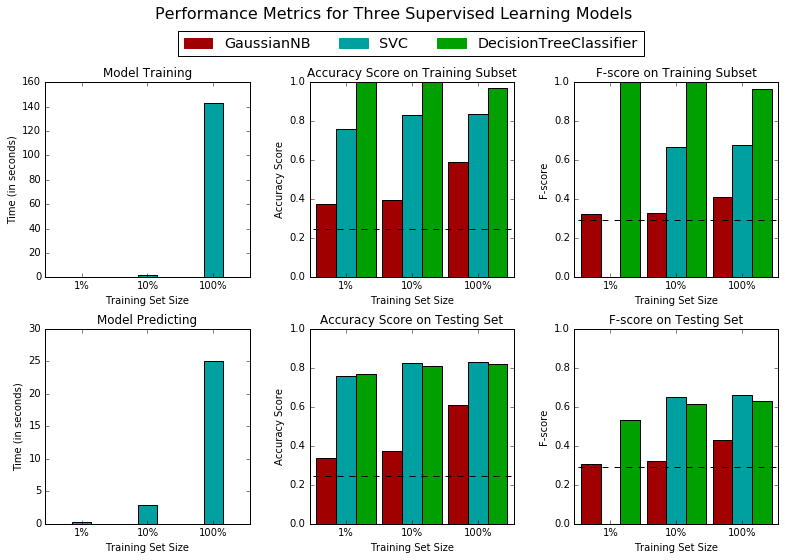

In [14]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(criterion="entropy",random_state=0)
clf_C = SVC(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
def get_sample_size(percentage):
    return int((float(percentage)/100)*n_records)

samples_1 = get_sample_size(1.0)
samples_10 = get_sample_size(10.0)
samples_100 = get_sample_size(100.0)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

Generally speaking, GaussianNB and DecisionTreeClassifier training times are in the same order of magnitude, with Support Vector Machines being the highest by far.  In terms of Prediction times, Support Vector Machines was also generally the highest.  In all cases, we can see improvements from the Naive "always rich" predictor developed earlier.

Despite this, Support Vector Machines have the most promising results on the testing set.  Hence, it is reccomended to choose the Support Vector Machines as a model. It has the most consistent performance regardless of training set size, and consistently delivers high F<sub>1</sub> scores around 0.8.  Decision Trees offer very similar performance to SVMs on the test set, and score highly on the training set - but this is most likely due to overfitting.  On the other hand, GaussianNB delivers a very un-robust and poor accuracy score of 0.3-0.75 on the test and training sets.  I would advise the selection of Support Vector Machines due to performance on the testing set based upon providing the highest accuracy and F-score.

Whilst SVMs appear to be influenced heavily by the size of the number of records, even with a large training and prediction time, it is likely that the model would be trained and used on occasion during funding roungs rather than persistently.  This is because such donors are typically targetted for more prestigious events such as Charity Dinners.  Considering this, performance and time are unlikely to be mission-critical even if order of magnitudes higher (i.e. seconds).  This means it is fine to stick with Support Vector Machines despite any performance concerns.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

Support Vector Machines (SVM) basically work by trying to identify the reasons why a student switches from a 'fail' to a 'pass'.  In other words, it isn't very concerned with people who are comfortably passing or failing, but rather what the differences are between students who have only *just* passed, or only *just* failed.   It will try to establish this *boundary* between marginal students as clearly as possible, thus enabling it to figure out what the most important factors are in getting students to pass.

Using knowledge about the data - for example, age, gender, family size, points (these are called *features*) we first plot them to establish relationships:

![Data Points](svm1.png)

For this drawing, the green dots are passed students, and the red ones are failed students.  The SVM algorithm then draws a boundary to try and seperate the passed students from the failed students:

![Data Points + Boundary](svm2.png)

We can see several plausable boundary lines here - but the objective of the SVM algorithm is to find the line with the maximum margin (solid line) and select that over a sub-optimal boundary (dashed lines).  By maximising the margin, we make the model as 'safe' as possible from error i.e. reduce passed students being mixed with failed and vice versa.

In reality, the data points are typically structured in much more complex ways, as with our student data.  We have to consider several features at once, and the relationships aren't so linear anymore:

![Complex Data + Boundary](svm3.png)

Here we can clearly see a curve or some other complex structure is required to seperate the data.  This means we have to do more than the basic SVM model and extend the functionality.  We achieve this by using mathematical functions, called 'kernels'.  What a kernel does is basically transform data points into a new dimension so that they can be seperable<sup>[7]</sup>:

![Kernel Trick 1](svm4.png)
![Kernel Trick 2](svm5.jpeg)

Here, the green points in particular are focused on and shifted onto a seperate dimension.  By then drawing a boundary across this dimension, the complex structure is now easily seperable by a linear boundary.

Once the boundary has been established, the model can use it to predict whether a student is going to pass or fail, depending on what side of the boundary a new data point is on.

<hr>

[7]M.  Elmezain, A.  Al-Hamadi, O.  Rashid and B.  Michaelis, "Posture and Gesture Recognition for Human-Computer Interaction", Advanced Technologies, 2009.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from IPython.display import display
import pickle, os.path

def f1_wrap(y_true, y_predict):
    return fbeta_score(y_true, y_predict, beta)

best_clf = None

# Note to mr mentor: I left my PC running overnight, so enable gridsearch with caution!
#     Probably best to modify the size of parameters grid before proceeding
GRID_SEARCH_ENABLED = True
if GRID_SEARCH_ENABLED:
    # Initialize the classifier
    clf = SVC(random_state=0)

    # Create the parameters list you wish to tune
    parameters = {'C':range(1,6),'kernel':['linear','poly','rbf','sigmoid'],'degree':range(1,6)}

    # Make an fbeta_score scoring object
    scorer = make_scorer(f1_wrap)

    # Perform grid search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters   
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_
    
    with open("best_clf.pkl", "w") as f:
        pickle.dump(best_clf, f, 2)
else:
    if os.path.isfile("best_clf.pkl"):
        with open("best_clf.pkl", "r") as f:
            best_clf = pickle.load(f)
    else:
        raise Exception("No tuned model exists.  Please enable Grid search.")
    

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

# Print the final parameters
df = pd.DataFrame(grid_fit.grid_scores_).sort_values('mean_validation_score').tail()
display(df)
print "Parameters for the optimal model: {}".format(clf.get_params())

Unoptimized model
------
Accuracy score on testing data: 0.8301
F-score on testing data: 0.6592

Optimized Model
------
Final accuracy score on the testing data: 0.8474
Final F-score on the testing data: 0.6996


,parameters,mean_validation_score,cv_validation_scores
4,"{u'kernel': u'linear', u'C': 1, u'degree': 2}",0.705546,"[0.700841009211, 0.70810510439, 0.707692307692]"
12,"{u'kernel': u'linear', u'C': 1, u'degree': 4}",0.705546,"[0.700841009211, 0.70810510439, 0.707692307692]"
8,"{u'kernel': u'linear', u'C': 1, u'degree': 3}",0.705546,"[0.700841009211, 0.70810510439, 0.707692307692]"
16,"{u'kernel': u'linear', u'C': 1, u'degree': 5}",0.705546,"[0.700841009211, 0.70810510439, 0.707692307692]"
0,"{u'kernel': u'linear', u'C': 1, u'degree': 1}",0.705546,"[0.700841009211, 0.70810510439, 0.707692307692]"


Parameters for the optimal model: {'kernel': 'rbf', 'C': 1.0, 'verbose': False, 'probability': False, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': None, 'random_state': 0, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 'auto', 'class_weight': None}


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              | 0.8301            | 0.8474          |
| F-score        | 0.2917              | 0.6592            | 0.6996          |


**Answer: **

* In terms of accuracy, the Optimized Model has improved performance by 1.5%, as the model has become better fitted to the data.  Relative to the benchmark, the Optimized Model is not significantly better than the optimized model, so perhaps is not worth the computation time.
* In terms of F-Score, the Optimized Model has a 4% increase in performance over the Unoptimized Model, suggesting a significant improvement in Precision and Recall.  Relative to the benchmark, this increase is still significant and suggests optimizing is worthwhile.

Given that the F-Score in particular has been able to reveal the advantage of optimizing the model, I would suggest the Charity ML continue to perform gridsearches and tuning.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [23]:
# Reminder of the features:
print(data.drop(['income'], axis=1).dtypes)

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
dtype: object


**Answer:**

Given that we're trying to establish the maximum amount of income, I would use the following 5 features:
- Education-num: Assuming people who are better educated can attain better jobs, this should have a strong impact on income levels
- marital-status: Those who earn more probably are more settled in life, and are likely to be married.
- age: Age typically directly correlates with level of income, as people are able to climb the career ladder.
- capitals-gain: Paying high amounts of capital gains tax suggests that this person has a lot of investments and is worth more.
- hours-per-week: Those who work a high number of hours per week most likely earn more, as this typically directly correlates with earnings.


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

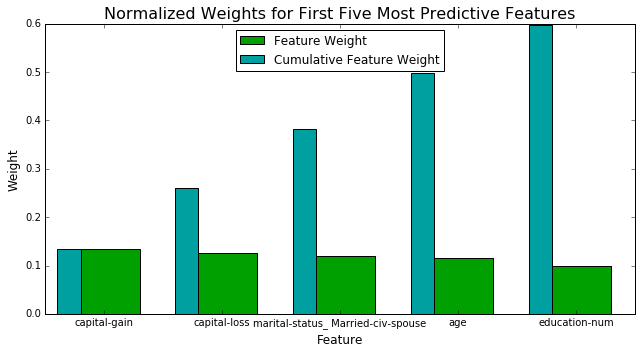

In [12]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier

# Train the supervised model on the training set 
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

The observations are largely consistent with the five features I discussed in the previous questions, with two exceptions:
- Hours per week: This turned out not to be a top-5 feature.  This could make sense, since typically those in working-class or lower paid jobs would typically be required to work longer hours but still earn less.
- Capital loss: Whilst I originally had assumed capital-loss suggests a loss in earnings, it appears to be another indicator of handling large investments and therefore wealth.

Interestingly, no feature in particular has great prominence.  with the top five features hovering around 10-15% importance.  This means that it is important to use a Machine Learning model which can interpret the multiple dimensions.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8474
F-score on testing data: 0.6996

Final Model trained on reduced data
------
Accuracy on testing data: 0.8367
F-score on testing data: 0.6742


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model | Reduced Features |
| :------------: | :-----------------: | :---------------: | :-------------: | :--------------: |
| Accuracy Score | 0.2478              | 0.8301            | 0.8474          | 0.8367
| F-score        | 0.2917              | 0.6592            | 0.6996          | 0.6742

As expected, reducing the number of features has a negative impact upon our model.  The optimized model has dropped in accuracy by around 1.1%, and the F-Score has dropped by around 0.025.

However, it still performs better than the unoptimzed model, which is impressive.  In particular, the F-score still sees significant improvements.

Since with an SVM, the training time is a large consideration, I would likely reduce the data set. However, the cumilative weight of the 5 most important features only give around 60% coverage.  I would consider picking the 6-8 most important features to achieve 75% coverage.  This would be a good middle ground between the time gains and keeping the complexity of the SVM model.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.